# Piecewise linear functions on triangulations

We test the two OMP algorithm on functions in two dimensions, $[0,1]^2$, that is we take $V = H_0^1([0,1]^2)$. We are approximating solutions $u(a(y))$ of the diffusion

We consider a dyadic level-$N$ uniform grid with spacing $\Delta x_{(N)} = 2^{-N}$. The solution is computed on the regular triangulation on this grid, evidently with $h=2^{-N}$. The field $a$ is a pw-constant function on a typically coarser grid, with spacing say $2^{-N_a}$, where $N_a \le N$. 

The dictionary $\mathcal{D}$ for the OMP algorithms consists of the representers of local integration, where the kernel for the local integration are hat-functions. The hat functions we consider are on the squares of size $2^{-N_\mathrm{hat}}$, again with $N_{\mathrm{hat}} \le N$.

That is, if $\mathrm{Hat}_{i,j}$ is the pw linear hat function on the square $[i 2^{-N_{\mathrm{hat}}}, (i+1) 2^{-N_{\mathrm{hat}}}) \times [j 2^{-N_{\mathrm{hat}}}, (j+1) 2^{-N_{\mathrm{hat}}})$, then $\mathcal{D}^{\mathrm{hat}}$ is the collection of functions $\omega_{i,j}$ such that
$$
\langle f, \omega_{i,j}\rangle_{H_0^1} = \int_{[0,1]^2} f \, \mathrm{Hat}_{i,j} \, \mathrm{d}x
$$

The measurement space $W_m$ is constructed such as to minimised $\beta(V_n, W_m)$, where $V_n$ is the provided approximation space. In this case $V_n$ is the space of random the solutions $u(a(y))$

In [1]:
import numpy as np
import scipy as sp
import math
import importlib
import seaborn as sns
import matplotlib.pyplot as plt
import pdb

import sys
sys.path.append("../../")
import pyApproxTools as pat
importlib.reload(pat)

%matplotlib inline

### Now we are going to set up a full dictionary of local integration points


In [2]:
fem_div = 7
field_div = 2

n = 50

np.random.seed(3)

Vn_sin = pat.make_pw_sin_basis(div=fem_div)
Vn_red, fields = pat.make_pw_reduced_basis(n, field_div=field_div, fem_div=fem_div)
Vn_red_o = Vn_red.orthonormalise()

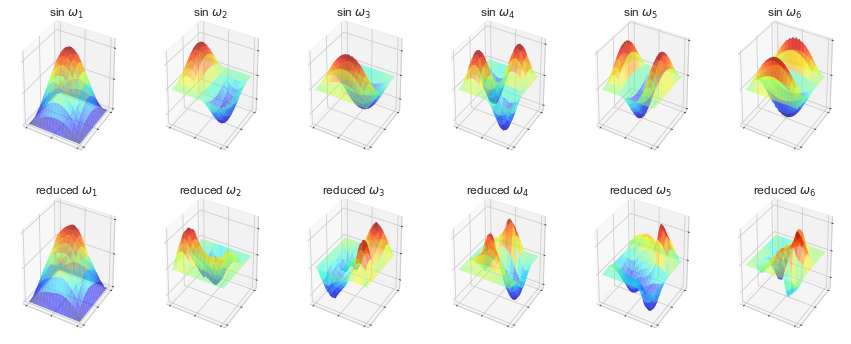

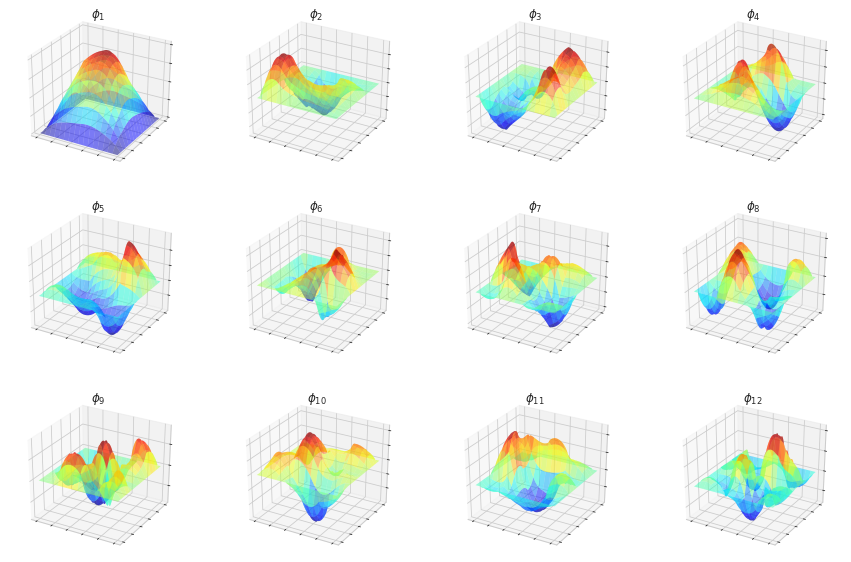

In [6]:
sns.set_style('whitegrid')
# Lets plot our measurment locations
fig = plt.figure(figsize=(15, 6))

disp = 6
for i in range(disp):
    ax1 = fig.add_subplot(2, disp, i+1, projection='3d')
    Vn_sin.vecs[i].plot(ax1, title=r'sin $\omega_{{{0}}}$'.format(i+1))
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_zticklabels([])
    ax1.set(xlabel='', ylabel='')
    ax2 = fig.add_subplot(2, disp, i+1+disp, projection='3d')
    Vn_red_o.vecs[i].plot(ax2, title=r'reduced $\omega_{{{0}}}$'.format(i+1))
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])
    ax2.set_zticklabels([])
    ax2.set(xlabel='', ylabel='')
plt.show()

fig = plt.figure(figsize=(15,10))
disp = 12
for i in range(disp):
    ax1 = fig.add_subplot(3, disp/3, i+1, projection='3d')
    Vn_red_o.vecs[i].plot(ax1, title=r'$\phi_{{{0}}}$'.format(i+1))
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_zticklabels([])
    ax1.set(xlabel='', ylabel='')
plt.savefig('Vn_RedBasisOrtho.pdf')
plt.show()

### Now examine the convergence of projections against a "snapshot" reduced basis and a sinusoidal basis

The idea being that we are examining the balance of both $\mu(V_n, W_m)$ and $\varepsilon$ with the two choices of approximation space

In [4]:
num_sol = 10
sols, sol_fields = pat.make_pw_reduced_basis(num_sol, field_div=field_div, fem_div=fem_div)
soln_col = sols.vecs

dist_sin = np.zeros((num_sol, n))
dist_red = np.zeros((num_sol, n))

for i, v in enumerate(soln_col):
    for j in range(1,n):
        P_v_sin = Vn_sin.subspace(slice(0,j)).project(v)
        P_v_red = Vn_red.subspace(slice(0,j)).project(v)
        
        dist_sin[i, j] = (v - P_v_sin).norm()
        dist_red[i, j] = (v - P_v_red).norm()

### Now we compare the OMP algorithm against both...  For now we do it here with n=20

In [5]:
width = 2

n = 20
m=150

print('Construct dictionary of local averages...')
D = pat.make_pw_hat_rep_dict(fem_div, width=width)

print('Worst-case greedy basis construction...')

wcbc = pat.WorstCaseOMP(D, Vn_sin.subspace(slice(0,20)), Wm=pat.PWBasis(), verbose=True)
Wm_wc_sin = wcbc.construct_to_m(m)
Wm_wc_sin_o = Wm_wc_sin.orthonormalise()

wcbc = pat.WorstCaseOMP(D, Vn_red_o.subspace(slice(0,20)), Wm=pat.PWBasis(), verbose=True)
Wm_wc_red = wcbc.construct_to_m(m)
Wm_wc_red_o = Wm_wc_red.orthonormalise()

bs_wc_sin = np.zeros(m)
bs_wc_red = np.zeros(m)

# For efficiency it makes sense to compute the basis pair and the associated
# cross-gramian only once, then sub sample it as we grow m...
BP_wc_sin_l = pat.BasisPair(Wm_wc_sin_o, Vn_sin.subspace(slice(0,20)))
BP_wc_red_l = pat.BasisPair(Wm_wc_red_o, Vn_red_o.subspace(slice(0,20)))

for i in range(n, m):
    BP_wc_sin =  BP_wc_sin_l.subspace(Wm_indices=slice(0,i))
    BP_wc_red =  BP_wc_red_l.subspace(Wm_indices=slice(0,i))

    bs_wc_sin[i] = BP_wc_sin.beta()
    bs_wc_red[i] = BP_wc_red.beta()

Construct dictionary of local averages...
Worst-case greedy basis construction...
i 	 || P_Vn (w - P_Wm w) ||
1 : 	 3638 	 0.1590537786089201
2 : 	 2882 	 0.2801365192952611
3 : 	 2789 	 0.3410373319464293
4 : 	 1244 	 0.41390213834722783
5 : 	 1211 	 0.4643939248245207
6 : 	 2066 	 0.3423677315088876
7 : 	 659 	 0.4361910131696603
8 : 	 3481 	 0.3478773740264345
9 : 	 3244 	 0.3576776177733958
10 : 	 683 	 0.31856523115264207
11 : 	 1845 	 0.31670471802330763
12 : 	 521 	 0.2995287346922212
13 : 	 2213 	 0.3647266704691417
14 : 	 3017 	 0.263903755428544
15 : 	 1220 	 0.319315133936476
16 : 	 3031 	 0.2627066961056933
17 : 	 2308 	 0.2754181539520168
18 : 	 1379 	 0.333665988695177
19 : 	 544 	 0.3973666747071516
20 : 	 1357 	 0.3144997801960467
21 : 	 512 	 0.34573776608856016
22 : 	 2548 	 0.27591772565656314
23 : 	 3520 	 0.2518791569303547
24 : 	 1456 	 0.3897007385332038
25 : 	 3442 	 0.31608420378523633
26 : 	 1742 	 0.291851504282979
27 : 	 3472 	 0.28018798024220315
28 : 	 244

92 : 	 2389 	 0.0796667240376736
93 : 	 1984 	 0.082637847194384
94 : 	 3376 	 0.06471502634731344
95 : 	 2309 	 0.07401947056293534
96 : 	 866 	 0.08188615721165429
97 : 	 2210 	 0.09628229046779058
98 : 	 913 	 0.07539827409572337
99 : 	 1606 	 0.11051713921483847
100 : 	 2756 	 0.09942608213448696
101 : 	 654 	 0.06620120214046153
102 : 	 1696 	 0.06969143432998415
103 : 	 2850 	 0.09536713968315366
104 : 	 2994 	 0.08256403093480721
105 : 	 3165 	 0.09209401584274657
106 : 	 1405 	 0.08431575548349887
107 : 	 1680 	 0.09186212693557831
108 : 	 2361 	 0.1236424631896563
109 : 	 1993 	 0.07114732777926219
110 : 	 1264 	 0.08232258308728847
111 : 	 957 	 0.0801097541430926
112 : 	 3740 	 0.08583937981791154
113 : 	 3724 	 0.06701908627236833
114 : 	 310 	 0.08350756332275813
115 : 	 231 	 0.07616272460921888
116 : 	 1228 	 0.07095111977931104
117 : 	 2352 	 0.07016256949283445
118 : 	 1348 	 0.06955674955514032
119 : 	 516 	 0.06694865197552444
120 : 	 2593 	 0.1058504410129483
121 : 

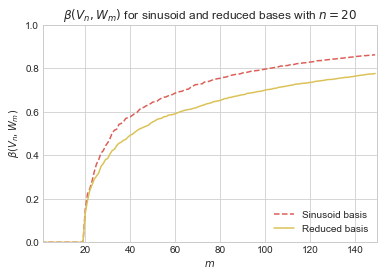

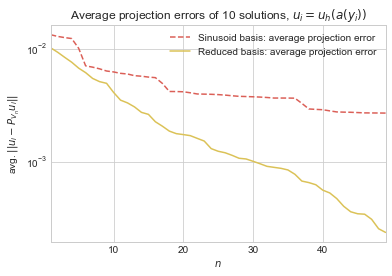

In [10]:
sns.set_style('whitegrid')
line_style = ['-', '--', ':', '-', '-.']

sns.set_palette("hls", 8)

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1, title=r'$\beta(V_n, W_m)$ for sinusoid and reduced bases with $n=20$')#, title=r'$\beta(V_n, W_m)$ against $m$ for various $n$')
    
plt.plot(range(m), bs_wc_sin, '--', label=r'Sinusoid basis')
plt.plot(range(m), bs_wc_red, label=r'Reduced basis')
ax.set(xlim=[1,m], ylim=[0,1], xlabel=r'$m$', ylabel=r'$\beta(V_n, W_m)$')
ax.legend(loc=4)
plt.savefig('SinVsRedBeta_new.pdf')
plt.show()  

n = 50
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1, title=r'Average projection errors of 10 solutions, $u_i = u_h(a(y_i))$')

cp = sns.color_palette("hls", 8)
#plt.semilogy(range(1,n), dist_sin[0, 1:], ':', color=cp[0], linewidth=1, label=r'Sinusois basis: proj error single vec')
#for i, v in enumerate(soln_col[1:]):
#    plt.semilogy(range(1,n), dist_sin[i, 1:], ':', color=cp[0], linewidth=1)
plt.semilogy(range(1,n), dist_sin[:,1:].mean(axis=0), '--', color=cp[0], label=r'Sinusoid basis: average projection error')
    
#plt.semilogy(range(1,n), dist_red[0, 1:], ':', color=cp[1], linewidth=1, label=r'Reduced basis: proj error single vec')
#for i, v in enumerate(soln_col[1:]):
#    plt.semilogy(range(1,n), dist_red[i, 1:], ':', color=cp[1], linewidth=1)
plt.semilogy(range(1,n), dist_red[:,1:].mean(axis=0), color=cp[1], label=r'Reduced basis: average projection error')
ax.set(xlim=[1,n-1], xlabel=r'$n$', ylabel=r'avg. $||u_i - P_{V_n} u_i ||$')
ax.legend(loc=1)
plt.savefig('SinVsRedProjErr_new.pdf')
plt.show()  